In [77]:
import pandas as pd
import os
from backtester.datahandler import HistoricalOptionsData

Our data has some zero values and missing entries that are inaccurate and could throw off our backtester, giving misleading results. We perform here a cleanup of the data.

In [ ]:
store_path = os.path.join("/Users/jrchatruc/Documents/backtester_options/allspx/", "options_data_v2_light.h5")
store = pd.HDFStore(store_path, complevel=9, complib="blosc", fletcher32=True)
underlying_dtype = pd.api.types.CategoricalDtype(
                categories=['SPX', 'SPXW', 'SPXPM'])

offset = 0
sizes = {"optionroot": 20, "optionalias": 20}
for year in range(1990, 2019):
    filename = "SPX_{}.csv".format(year)
    year_df = pd.read_csv(os.path.join("/Users/jrchatruc/Documents/backtester_options/allspx/", filename),
                          parse_dates=["expiration", "quotedate"])
    year_df.rename(columns={" exchange": "exchange"}, inplace=True)
    year_df = year_df.astype({"strike": "float", "optionalias": "object", "type": "category",
                              'underlying': underlying_dtype})
    year_df = year_df.drop('optionext', axis=1)
    year_df = year_df.drop('exchange', axis=1)
    year_df = year_df.reset_index(drop=True)
    year_df.index += offset
    offset += len(year_df)
    store.append("/SPX", year_df, index=False, data_columns=True, min_itemsize=sizes)
    print(year)

In [79]:
store.close()

In [ ]:
%cd -q /Users/jrchatruc/Documents/backtester_options/allspx
!ptrepack --complevel=9 --complib=blosc options_data_v2_light.h5 options_data_v2_light_compressed.h5

In [95]:
data = HistoricalOptionsData("options_data_v2_light_compressed.h5", key="/SPX")
schema = data.schema
df = data._data

In [96]:
df.shape

(16756680, 19)

In [97]:
df[(df['bid'] == 0) & (df['ask'] == 0)].shape[0] / df.shape[0]

0.065681208926828

As can be seen, around $6.5\%$ of the rows have both their bid and ask equal to zero. Some of these are because these values are going progressively down until they reach around $0.1$ or $0.05$, at which point they (sometimes) get replaced with zero. This isn't a problematic case, but it is not the only one.

In [98]:
# A (mostly) innocuous contract, its bid and ask values are always very close to zero, so them dipping into zero
# is not a problem.
df[df['optionroot'] == 'SPX191220P00100000']

,underlying,underlying_last,optionroot,type,expiration,quotedate,strike,last,bid,ask,volume,openinterest,impliedvol,delta,gamma,theta,vega,optionalias,dte
13359109,SPX,2276.98,SPX191220P00100000,put,2019-12-20,2017-01-06,100.0,0.15,0.10,0.15,20,773,0.3185,0.0000,0.0,0.0000,0.0000,SPX191220P00100000,1078
13388755,SPX,2275.32,SPX191220P00100000,put,2019-12-20,2017-01-11,100.0,0.15,0.10,0.15,0,783,0.5958,-0.0002,0.0,-0.2454,2.4561,SPX191220P00100000,1073
13400173,SPX,2270.44,SPX191220P00100000,put,2019-12-20,2017-01-12,100.0,0.15,0.10,0.15,1,783,0.5940,-0.0002,0.0,-0.2466,2.4588,SPX191220P00100000,1072
13411669,SPX,2274.64,SPX191220P00100000,put,2019-12-20,2017-01-13,100.0,0.11,0.10,0.15,0,785,0.5963,-0.0002,0.0,-0.2458,2.4539,SPX191220P00100000,1071
13423111,SPX,2267.89,SPX191220P00100000,put,2019-12-20,2017-01-17,100.0,0.10,0.10,0.15,0,805,0.5986,-0.0002,0.0,-0.2453,2.4442,SPX191220P00100000,1067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16740413,SPX,2351.10,SPX191220P00100000,put,2019-12-21,2018-12-24,100.0,0.05,0.05,0.10,530,14541,0.3500,0.0000,0.0,0.0000,0.0000,NaN,362
16744107,SPX,2467.70,SPX191220P00100000,put,2019-12-21,2018-12-26,100.0,0.05,0.00,0.10,0,15059,0.3219,0.0000,0.0,0.0000,0.0000,NaN,360
16747947,SPX,2488.83,SPX191220P00100000,put,2019-12-21,2018-12-27,100.0,0.05,0.00,0.05,0,15059,0.3314,0.0000,0.0,0.0000,0.0000,NaN,359
16751791,SPX,2485.74,SPX191220P00100000,put,2019-12-21,2018-12-28,100.0,0.05,0.00,0.05,500,15059,0.3256,0.0000,0.0,0.0000,0.0000,NaN,358


This next contract, however, is a problem. On first inspection it looks fine, but it actually contains a lot of zero values intermingled.

In [99]:
problematic = df[df['optionroot'] == 'SPX910622C00300000']
problematic

,underlying,underlying_last,optionroot,type,expiration,quotedate,strike,last,bid,ask,volume,openinterest,impliedvol,delta,gamma,theta,vega,optionalias,dte
144,SPX,359.69,SPX910622C00300000,call,1991-06-22,1990-01-02,300.0,0.0,94.3,94.3,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,SPX910622C00300000,536
314,SPX,358.76,SPX910622C00300000,call,1991-06-22,1990-01-03,300.0,0.0,93.3,93.3,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,SPX910622C00300000,535
484,SPX,355.66,SPX910622C00300000,call,1991-06-22,1990-01-04,300.0,0.0,90.2,90.2,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,SPX910622C00300000,534
654,SPX,352.20,SPX910622C00300000,call,1991-06-22,1990-01-05,300.0,0.0,86.6,86.6,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,SPX910622C00300000,533
824,SPX,353.79,SPX910622C00300000,call,1991-06-22,1990-01-08,300.0,0.0,88.1,88.1,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,SPX910622C00300000,530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68132,SPX,380.13,SPX910622C00300000,call,1991-06-22,1991-06-17,300.0,81.5,80.4,80.9,1,3728,1.0531,0.9832,0.0010,-0.2442,0.0173,SPX910622C00300000,5
68330,SPX,378.59,SPX910622C00300000,call,1991-06-22,1991-06-18,300.0,0.0,78.5,79.0,0,3727,1.4422,0.9608,0.0016,-0.6967,0.0307,SPX910622C00300000,4
68528,SPX,375.09,SPX910622C00300000,call,1991-06-22,1991-06-19,300.0,75.5,75.0,76.0,756,3727,1.6634,0.9598,0.0017,-0.9583,0.0260,SPX910622C00300000,3
68726,SPX,375.42,SPX910622C00300000,call,1991-06-22,1991-06-20,300.0,0.0,75.0,76.0,0,3557,1.8106,0.9824,0.0011,-0.7040,0.0099,SPX910622C00300000,2


In [100]:
problematic[4:20]

,underlying,underlying_last,optionroot,type,expiration,quotedate,strike,last,bid,ask,volume,openinterest,impliedvol,delta,gamma,theta,vega,optionalias,dte
824,SPX,353.79,SPX910622C00300000,call,1991-06-22,1990-01-08,300.0,0.0,88.1,88.1,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,SPX910622C00300000,530
994,SPX,349.62,SPX910622C00300000,call,1991-06-22,1990-01-09,300.0,0.0,83.8,83.8,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,SPX910622C00300000,529
1164,SPX,347.31,SPX910622C00300000,call,1991-06-22,1990-01-10,300.0,0.0,81.4,81.4,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,SPX910622C00300000,528
1334,SPX,348.53,SPX910622C00300000,call,1991-06-22,1990-01-11,300.0,0.0,82.6,82.6,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,SPX910622C00300000,527
1504,SPX,339.93,SPX910622C00300000,call,1991-06-22,1990-01-12,300.0,0.0,0.0,0.0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,SPX910622C00300000,526
1674,SPX,337.00,SPX910622C00300000,call,1991-06-22,1990-01-15,300.0,0.0,70.8,70.8,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,SPX910622C00300000,523
1844,SPX,340.75,SPX910622C00300000,call,1991-06-22,1990-01-16,300.0,0.0,74.5,74.5,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,SPX910622C00300000,522
2026,SPX,337.40,SPX910622C00300000,call,1991-06-22,1990-01-17,300.0,0.0,71.1,71.1,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,SPX910622C00300000,521
2208,SPX,338.19,SPX910622C00300000,call,1991-06-22,1990-01-18,300.0,0.0,0.0,0.0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,SPX910622C00300000,520
2391,SPX,339.15,SPX910622C00300000,call,1991-06-22,1990-01-19,300.0,0.0,0.0,0.0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,SPX910622C00300000,519


In [101]:
problematic[problematic['bid'] == 0].shape

(34, 19)

Of $373$ total rows, $34$ of them have their bid equal to zero even though the non-zero values in between are never even close to zero. These types of contracts happen all throughout the dataset and need to be addressed. We will drop contracts that have an entry with both their ask and bid equal to zero. This means of course that we will also be dropping some contracts with correct values, but we are willing to make that tradeoff.

Here's an example of a contract with all its bid and ask entries set to zero.

In [102]:
df[df['optionroot'] == 'SPX920718P00250000']

,underlying,underlying_last,optionroot,type,expiration,quotedate,strike,last,bid,ask,volume,openinterest,impliedvol,delta,gamma,theta,vega,optionalias,dte
117271,SPX,409.76,SPX920718P00250000,put,1992-07-18,1992-06-12,250.0,0.000,0.0,0.0,0,0,0.5202,-0.0008,0.0,-0.0025,0.0035,SPX920718P00250000,36
117505,SPX,410.29,SPX920718P00250000,put,1992-07-18,1992-06-15,250.0,0.031,0.0,0.0,250,0,0.5463,-0.0008,0.0,-0.0028,0.0034,SPX920718P00250000,33
117743,SPX,408.32,SPX920718P00250000,put,1992-07-18,1992-06-16,250.0,0.000,0.0,0.0,0,0,0.5485,-0.0008,0.0,-0.0029,0.0033,SPX920718P00250000,32
117981,SPX,402.26,SPX920718P00250000,put,1992-07-18,1992-06-17,250.0,0.000,0.0,0.0,0,250,0.5408,-0.0008,0.0,-0.0029,0.0033,SPX920718P00250000,31
118219,SPX,400.96,SPX920718P00250000,put,1992-07-18,1992-06-18,250.0,0.000,0.0,0.0,0,250,0.5452,-0.0009,0.0,-0.0031,0.0033,SPX920718P00250000,30
118457,SPX,403.67,SPX920718P00250000,put,1992-07-18,1992-06-19,250.0,0.000,0.0,0.0,0,250,0.5618,-0.0008,0.0,-0.0032,0.0032,SPX920718P00250000,29
118645,SPX,403.40,SPX920718P00250000,put,1992-07-18,1992-06-22,250.0,0.000,0.0,0.0,0,250,0.5933,-0.0008,0.0,-0.0035,0.0030,SPX920718P00250000,26
118833,SPX,404.04,SPX920718P00250000,put,1992-07-18,1992-06-23,250.0,0.000,0.0,0.0,0,250,0.6072,-0.0008,0.0,-0.0037,0.0030,SPX920718P00250000,25
119021,SPX,403.84,SPX920718P00250000,put,1992-07-18,1992-06-24,250.0,0.000,0.0,0.0,0,250,0.6194,-0.0008,0.0,-0.0039,0.0029,SPX920718P00250000,24
119209,SPX,403.12,SPX920718P00250000,put,1992-07-18,1992-06-25,250.0,0.000,0.0,0.0,0,250,0.6311,-0.0008,0.0,-0.0040,0.0029,SPX920718P00250000,23


Another issue are contracts with missing entries like the following, which stops showing up at 358 dte (it also has almost all rows with both ask and bid set to zero, so this is a particularly problematic contract).

In [109]:
df[df['optionroot'] == 'SXG031220P01450000']

,underlying,underlying_last,optionroot,type,expiration,quotedate,strike,last,bid,ask,volume,openinterest,impliedvol,delta,gamma,theta,vega,optionalias,dte
1120981,SPX,1165.25,SXG031220P01450000,put,2003-12-20,2002-01-03,1450.0,0.0,0.0,0.0,0,0,0.1837,-0.7189,0.0011,-4.9932,550.1433,SXG031220P01450000,716
1121467,SPX,1172.50,SXG031220P01450000,put,2003-12-20,2002-01-04,1450.0,0.0,0.0,0.0,0,200,0.1780,-0.7198,0.0012,-4.3687,552.3557,SXG031220P01450000,715
1121957,SPX,1164.90,SXG031220P01450000,put,2003-12-20,2002-01-07,1450.0,0.0,0.0,0.0,0,200,0.1820,-0.7230,0.0011,-4.5666,544.5476,SXG031220P01450000,712
1122447,SPX,1160.70,SXG031220P01450000,put,2003-12-20,2002-01-08,1450.0,0.0,0.0,0.0,0,200,0.1830,-0.7265,0.0011,-4.3912,538.8742,SXG031220P01450000,711
1122940,SPX,1155.15,SXG031220P01450000,put,2003-12-20,2002-01-09,1450.0,0.0,0.0,0.0,0,200,0.1846,-0.7304,0.0011,-4.2222,532.0289,SXG031220P01450000,710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1265123,SPX,895.82,SXG031220P01450000,put,2003-12-20,2002-12-20,1450.0,0.0,0.0,0.0,0,2421,0.2241,-0.9648,0.0002,1.5314,43.4461,SXG031220P01450000,365
1265633,SPX,897.38,SXG031220P01450000,put,2003-12-20,2002-12-23,1450.0,0.0,0.0,0.0,0,2421,0.2170,-0.9666,0.0002,0.5313,36.1597,SXG031220P01450000,362
1266143,SPX,892.47,SXG031220P01450000,put,2003-12-20,2002-12-24,1450.0,0.0,0.0,0.0,0,2419,0.2175,-0.9667,0.0002,-0.1834,33.7203,SXG031220P01450000,361
1266653,SPX,889.66,SXG031220P01450000,put,2003-12-20,2002-12-26,1450.0,0.0,0.0,0.0,0,2419,0.2145,-0.9651,0.0002,-3.3717,28.2564,SXG031220P01450000,359


Once again, we will drop contracts with missing entries.

In [26]:
unique_contracts_per_day = df.groupby('quotedate').apply(lambda x: x['optionroot'].nunique())

Let's plot the number of contracts per day to compare after the cleanup.

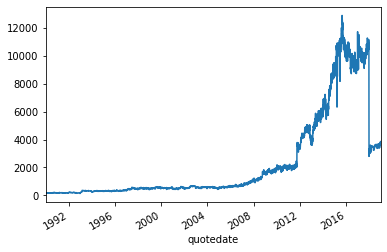

In [28]:
unique_contracts_per_day.plot();

In [71]:
# to_clean is a set with the contracts with missing entries to then drop.
current_contracts = set()
to_clean = set()
for _, options in df.groupby('quotedate'):
    current_contracts = current_contracts.union(set(options['optionroot']))
    current_contracts = current_contracts.difference(set(options[options['dte'] <= 1]['optionroot']))
    missing_contracts = current_contracts.difference(set(options['optionroot']))
    to_clean = to_clean.union(missing_contracts)
to_clean = to_clean.union(current_contracts)

In [54]:
to_clean_df = df[df['optionroot'].isin(list(to_clean))]

In [55]:
new_df = df.drop(to_clean_df.index)

In [56]:
new_df.reset_index(inplace=True, drop=True)

In [57]:
# Drop the contracts that have a row with both their ask and bid zero.
contracts_with_zero = new_df[(new_df['ask'] == 0) & (new_df['bid'] == 0)]['optionroot'].unique()

In [58]:
final_df = new_df.drop(new_df[new_df['optionroot'].isin(contracts_with_zero)].index)

In [59]:
final_df.reset_index(inplace=True, drop=True)

In [72]:
final_df['optionroot'].nunique() / df['optionroot'].nunique()

0.6339574482236837

In [64]:
final_df.shape

(9245562, 19)

In [103]:
unique_contracts_per_day_final = final_df.groupby('quotedate').apply(lambda x: x['optionroot'].nunique())

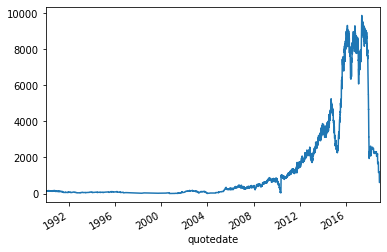

In [105]:
unique_contracts_per_day_final.plot();

In [66]:
store_path = os.path.join("/Users/jrchatruc/Documents/backtester_options/allspx/", "options_data_v2_pruned.h5")
store = pd.HDFStore(store_path, complevel=9, complib="blosc", fletcher32=True)

In [68]:
sizes = {"optionroot": 20, "optionalias": 20}
store.append("/SPX", final_df, index=False, data_columns=True, min_itemsize=sizes)

In [69]:
store.close()

In [70]:
%cd -q /Users/jrchatruc/Documents/backtester_options/allspx
!ptrepack --complevel=9 --complib=blosc options_data_v2_pruned.h5 options_data_v2_pruned_compressed.h5